In [1]:
from Subspace import Subspace
from Inference import Inference 
from model import Model
import matplotlib.pyplot as plt
from autograd import numpy as np



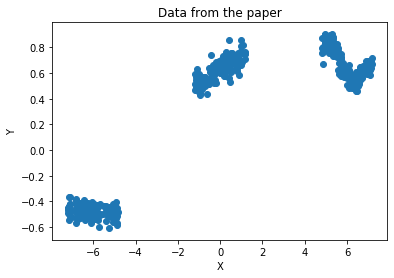

In [2]:
# visualize the data used in original paper
data = np.load('../example/data.npy')
x, y = data[:, 0], data[:, 1]
plt.scatter(x, y)
plt.title('Data from the paper')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Fitting the Neural Network

In [3]:
alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c) ** 2)

###neural network model design choices

width = 7 #7
hidden_layers = 2 #2
input_dim = 1
output_dim = 1

architecture = {'width': width,
                'hidden_layers': hidden_layers,
                'input_dim': input_dim,
                'output_dim': output_dim,
                'activation_fn_type': 'rbf',
                'activation_fn_params': 'c=0, alpha=1',
                'activation_fn': h}

# set random state to make the experiments replicable
rand_state = 127
random = np.random.RandomState(rand_state)

# create a model and train the model
my_nn = Model.create(submodel_type="Feedforward", architecture=architecture)

# use MSE result as params_init
params = {'step_size': 1e-3, #1e-3
          'max_iteration': 5000, #5000
          'random_restarts': 1}

# fit my neural network to minimize MSE on the given data
my_nn.fit(x_train=x.reshape((1, -1)), y_train=y.reshape((1, -1)), params=params)

Iteration 0 lower bound 289.3001853084916; gradient mag: 990.2060364926602
Iteration 100 lower bound 107.0780461869004; gradient mag: 145.49567971593677
Iteration 200 lower bound 93.3218528910101; gradient mag: 43.398098804648946
Iteration 300 lower bound 87.36705042632238; gradient mag: 50.47577938922759
Iteration 400 lower bound 77.04110606687772; gradient mag: 72.61696586725114
Iteration 500 lower bound 55.11953246275229; gradient mag: 101.66465905368601
Iteration 600 lower bound 21.459547007887842; gradient mag: 101.59721452823686
Iteration 700 lower bound 5.8144928341375355; gradient mag: 35.611762336360506
Iteration 800 lower bound 4.191846344429371; gradient mag: 7.386818658743642
Iteration 900 lower bound 3.919625535317175; gradient mag: 4.610261963649015
Iteration 1000 lower bound 3.7577506249513473; gradient mag: 3.9477122958420194
Iteration 1100 lower bound 3.6264128529472597; gradient mag: 3.548539592941056
Iteration 1200 lower bound 3.5060894882556335; gradient mag: 3.2944

Text(0, 0.5, 'Y')

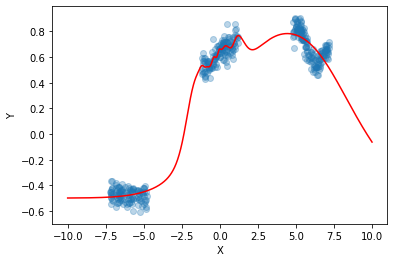

In [4]:
# visualize the model's prediction
x_test = np.linspace(-10, 10, 1000).reshape(1,-1)
y_test = my_nn.forward(x_test, use_subweights = False, weights = my_nn.weights)[0]
plt.scatter(x, y, alpha = 0.3)
plt.plot(x_test[0], y_test[0], color = 'red')
plt.xlabel('X')
plt.ylabel('Y')


## HMC + Random Subspace

In [11]:
### HMC + random
# set up model, subspace, inference

my_subspace = Subspace.create(subspace_type="random", model=my_nn, n_subspace=2)
my_subspace.collect_vector(X=x, y=y)
P, w = my_subspace.get_space()
hmc_tune_params={'step_size': 1e-2, #1e-2
                'leapfrog_steps': 10, #10
                'total_samples': 1000,
                'burn_in': 0.1,
                'warm_start': True,
                'thinning_factor': 1, #1
                'mom_std': 1, #1
                'diagnostic_mode': False}
my_inference = Inference.create(inference_type="HMC", model=my_nn, P=P, w_hat=w,  tune_params=hmc_tune_params)


# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=P, w_hat=w)

# train
# for HMC
my_inference.train(X=x, y=y, warm_start=True, position_init=position_init)

HMC 200: accept rate of 75.5
HMC 400: accept rate of 76.25
HMC 600: accept rate of 76.33333333333333
HMC 800: accept rate of 76.875


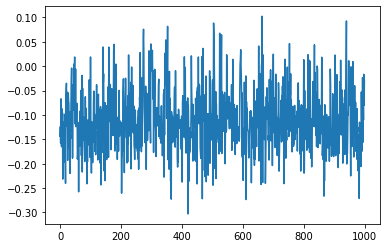

In [12]:
plt.plot(my_inference.get_posterior(1000)[:,0])

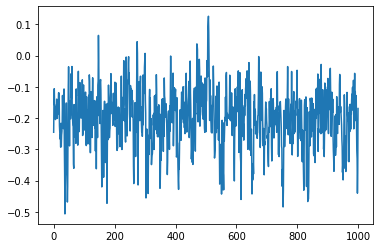

In [13]:
plt.plot(my_inference.get_posterior(5000)[:,1])

In [18]:
my_nn.get_W_from_z(z_samples[-1], P, w)-my_nn.weights

array([[ -0.13364863,   0.74032625,   0.30861053, ...,   1.72462631,
          1.69692814,   1.46216417],
       [ -3.95692703,  -3.08295215,  -3.51466788, ...,  -2.09865209,
         -2.12635026,  -2.36111423],
       [-11.54573864, -10.67176377, -11.10347949, ...,  -9.68746371,
         -9.71516187,  -9.94992585],
       ...,
       [  9.83251483,  10.70648971,  10.27477399, ...,  11.69078977,
         11.6630916 ,  11.42832763],
       [  6.73094301,   7.60491789,   7.17320217, ...,   8.58921795,
          8.56151978,   8.32675581],
       [ -0.80518822,   0.06878666,  -0.36292906, ...,   1.05308672,
          1.02538856,   0.79062458]])

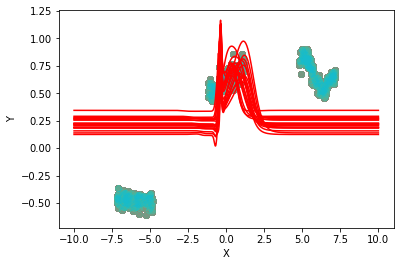

In [17]:
n = 20
z_samples = my_inference.get_posterior(n_samples = n)
for i in range(n):
    x_test = np.linspace(-10, 10, 1000).reshape(1,-1)
    y_test = my_nn.forward(P=P, w_hat=w, z=z_samples[i], X = x_test)[0]
    plt.scatter(x, y, alpha = 0.3)
    plt.plot(x_test[0], y_test[0], color = 'red')
    plt.xlabel('X')
    plt.ylabel('Y')

## HMC + PCA Subspace

In [27]:
### HMC + pca
# set up model, subspace, inference

my_subspace = Subspace.create(subspace_type="pca", model=my_nn, n_subspace=2)
my_subspace.collect_vector(X=x, y=y)
P, w = my_subspace.get_space()
hmc_tune_params={'step_size': 1e-4, #1e-2
                'leapfrog_steps': 10, #10
                'total_samples': 1000,
                'burn_in': 0.1,
                'warm_start': True,
                'thinning_factor': 1, #1
                'mom_std': 1, #1
                'diagnostic_mode': False} #这里不管怎么调都不converge 
my_inference = Inference.create(inference_type="HMC", model=my_nn, P=P, w_hat=w,  tune_params=hmc_tune_params)


# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=P, w_hat=w)

# train
# for HMC
my_inference.train(X=x, y=y, warm_start=True, position_init=position_init)

HMC 200: accept rate of 100.0
HMC 400: accept rate of 99.75
HMC 600: accept rate of 99.83333333333333
HMC 800: accept rate of 99.75


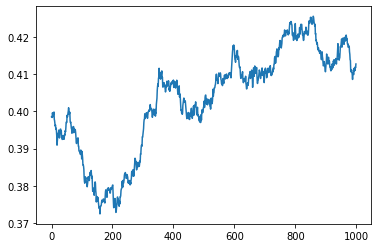

In [28]:
plt.plot(my_inference.get_posterior(1000)[:,0])

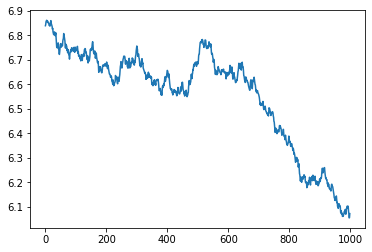

In [26]:
plt.plot(my_inference.get_posterior(1000)[:,1])

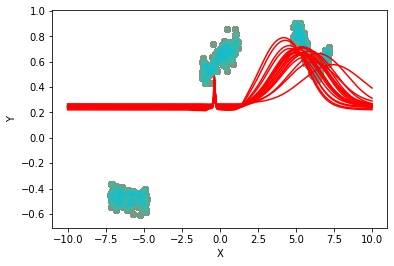

In [23]:
n = 20
z_samples = my_inference.get_posterior(n_samples = n)
for i in range(n):
    x_test = np.linspace(-10, 10, 1000).reshape(1,-1)
    y_test = my_nn.forward(P=P, w_hat=w, z=z_samples[i], X = x_test)[0]
    plt.scatter(x, y, alpha = 0.3)
    plt.plot(x_test[0], y_test[0], color = 'red')
    plt.xlabel('X')
    plt.ylabel('Y')

## BBB + Random Subspace

In [5]:
### BBVI + random
# set up model, subspace, inference

my_subspace = Subspace.create(subspace_type="random", model=my_nn, n_subspace=2)
my_subspace.collect_vector(X=x, y=y)
P, w = my_subspace.get_space()
my_inference = Inference.create(inference_type="BBB", model=my_nn, P=P, w_hat=w)


# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=P, w_hat=w)

# train
# for BBB
my_inference.train(X=x, y=y, warm_start=True, init_mean=position_init)

ValueError: operands could not be broadcast together with shapes (400,) (40000,) 

In [ ]:
# extract mean and variance for 2 parameters
mean1 = my_inference.optimal_trace[:, 0]
mean2 = my_inference.optimal_trace[:, 1]
var1 = my_inference.optimal_trace[:, 2]
var2 = my_inference.optimal_trace[:, 3]

plt.plot(mean1, label = 'z1')
plt.plot(mean2, label = 'z2')
plt.title('traces of mean')
plt.xlabel('t')
plt.ylabel('mean')
plt.legend()
plt.show()

In [ ]:
plt.plot(var1, label = 'z1')
plt.plot(var2, label = 'z2')
plt.title('traces of variance')
plt.xlabel('t')
plt.ylabel('var')
plt.legend()
plt.show()

In [ ]:
for i in range(100):
    z1_sample, z2_sample = np.random.multivariate_normal(my_inference.variational_mu, my_inference.variational_Sigma)
    x_test = np.linspace(-10, 10, 1000).reshape(1,-1)
    y_test = my_nn.forward(P=P, w_hat=w, z=np.array([z1_sample, z2_sample]), X = x_test)[0]
    plt.scatter(x, y, alpha = 0.3)
    plt.plot(x_test[0], y_test[0], color = 'red')
    plt.xlabel('X')
    plt.ylabel('Y')

## Koko's Initial Test Code 

expected output:

[ 0.00387721 -0.00174438  0.17640523  0.04001572]
Iteration 0 lower bound -943.9098004093116; gradient mag: 515.2085302434132
[ 0.54710764 -0.36653886 -2.73041826 -3.18870097]
Iteration 200 lower bound -775.4743018275966; gradient mag: 43.86028502745455
[ 0.55682394 -0.35555479 -3.28712542 -3.54177566]
Iteration 400 lower bound -778.4579125109132; gradient mag: 19.15529966330564
[ 0.54731118 -0.36700774 -3.43286884 -3.87303312]
Iteration 600 lower bound -783.1594511505094; gradient mag: 33.68011942690907
[ 0.55679421 -0.3624546  -3.49317436 -3.91809697]
Iteration 800 lower bound -776.71724208354; gradient mag: 27.549842240122263


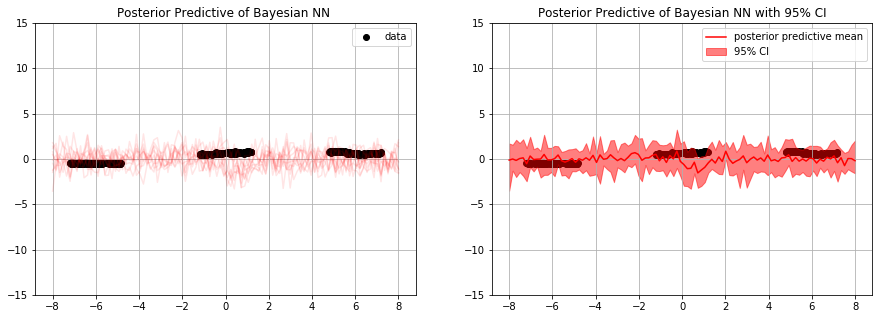

In [52]:
# get posterior z
n_sample = 10
post_sample = my_inference.get_posterior(n_samples=n_sample).reshape(-1, 2)
x_test = np.linspace(-8, 8, 100)
y_test = np.reshape(
    [my_nn.forward(P=P, w_hat=w, z=post_sample[i], X=x_test.reshape(1, -1)) for i in range(n_sample)],
    (n_sample, -1)) \
         + np.random.normal(0, my_nn.Sigma_Y_det ** 0.5, size=(n_sample, len(x_test)))
# because here Sigma_Y is 1-D, so determinants=its value

# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN ')
plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test, 0.25, axis=0), np.percentile(y_test, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI')
plt.grid()
plt.ylim(-15, 15)
plt.show()

Now Koko's code doesn't work because of the BBB bug.

In [7]:
# test
# print("All possible models:{}".format(Model.modeltype))
data = np.load('../example/data.npy')
# data = np.load('data.npy')
x, y = data[:, 0], data[:, 1]

alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c) ** 2)

###neural network model design choices
width = 5
hidden_layers = 1
input_dim = 1
output_dim = 1

architecture = {'width': width,
                'hidden_layers': hidden_layers,
                'input_dim': input_dim,
                'output_dim': output_dim,
                'activation_fn_type': 'rbf',
                'activation_fn_params': 'c=0, alpha=1',
                'activation_fn': h}
# set random state to make the experiments replicable
rand_state = 127
random = np.random.RandomState(rand_state)

# ---------------- Core thing! ------------------ #
# set up model, subspace, inference
my_nn = Model.create(submodel_type="Feedforward", architecture=architecture)
my_subspace = Subspace.create(subspace_type="random", model=my_nn, n_subspace=2)
my_subspace.collect_vector(X=x, y=y)
P, w = my_subspace.get_space()
# my_inference = Inference.create(inference_type="HMC", model=my_nn, P=P, w_hat=w)
my_inference = Inference.create(inference_type="BBB", model=my_nn, P=P, w_hat=w)

# use MSE result as params_init
params = {'step_size': 1e-3,
          'max_iteration': 5000,
          'random_restarts': 1}

# fit my neural network to minimize MSE on the given data
my_nn.fit(x_train=x.reshape((1, -1)), y_train=y.reshape((1, -1)), params=params)

# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=P, w_hat=w)
# # notice since P from PCA is too small (almost 1e-16), the inversed z is too large! Maybe sth wrong at PCA!
# so if P is too small, it is better to start with position_init=None

# train
# for HMC
# my_inference.train(X=x, y=y, warm_start=True, position_init=position_init)
# for BBB
my_inference.train(X=x, y=y, warm_start=True, init_mean=position_init)

# get posterior z
n_sample = 10
post_sample = my_inference.get_posterior(n_samples=n_sample).reshape(-1, 2)
x_test = np.linspace(-8, 8, 100)
y_test = np.reshape(
    [my_nn.forward(P=P, w_hat=w, z=post_sample[i], X=x_test.reshape(1, -1)) for i in range(n_sample)],
    (n_sample, -1)) \
         + np.random.normal(0, my_nn.Sigma_Y_det ** 0.5, size=(n_sample, len(x_test)))
# because here Sigma_Y is 1-D, so determinants=its value

# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN ')
plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test, 0.25, axis=0), np.percentile(y_test, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI')
plt.grid()
plt.ylim(-15, 15)
plt.show()

Iteration 0 lower bound 346.63368004153597; gradient mag: 922.7651717672313
Iteration 100 lower bound 195.22009224300444; gradient mag: 417.619792247884
Iteration 200 lower bound 137.45046392571888; gradient mag: 226.84888453436002
Iteration 300 lower bound 114.74074161539443; gradient mag: 124.16169113155684
Iteration 400 lower bound 105.52134922138134; gradient mag: 71.2162223486273
Iteration 500 lower bound 101.23821149973587; gradient mag: 47.19006844681675
Iteration 600 lower bound 98.76737682575583; gradient mag: 36.27749198954713
Iteration 700 lower bound 97.05576335434516; gradient mag: 29.77442843030472
Iteration 800 lower bound 95.71597544654082; gradient mag: 24.876678953752624
Iteration 900 lower bound 94.56053908767345; gradient mag: 20.988474889540583
Iteration 1000 lower bound 93.51846194338967; gradient mag: 17.91479205203372
Iteration 1100 lower bound 92.64578376718416; gradient mag: 15.320337462037504
Iteration 1200 lower bound 92.01095544458073; gradient mag: 12.9151

ValueError: operands could not be broadcast together with shapes (400,) (40000,) 